In [3]:
using BenchmarkTools
using CUDAnative, CuArrays
using GPUifyLoops
using PyPlot

In [4]:
# Increment integer with periodic wrapping.
@inline incmod1(a, n) = a == n ? 1 : a+1

incmod1 (generic function with 1 method)

In [5]:
# x, y, and z difference operators with periodic boundary conditions.
# Nx, Ny, and Nz are the number of grid points in each dimension.
# They return the difference at grid point (i, j, k).
@inline δx(f, Nx, i, j, k) = @inbounds f[incmod1(i, Nx), j, k] - f[i, j, k]
@inline δy(f, Ny, i, j, k) = @inbounds f[i, incmod1(j, Ny), k] - f[i, j, k]
@inline δz(f, Nz, i, j, k) = @inbounds f[i, j, incmod1(k, Nz)] - f[i, j, k]

# 3D Divergence operator.
@inline div(f, Nx, Ny, Nz, Δx, Δy, Δz, i, j, k) = δx(f, Nx, i, j, k) / Δx + δy(f, Ny, i, j, k) / Δy + δz(f, Nz, i, j, k) / Δz

div (generic function with 1 method)

In [18]:
# This is the actual kernel.
function div_kernel(::Val{Dev}, f, div_f) where Dev
    @setup Dev
    
    Nx, Ny, Nz = size(f)
    Δx, Δy, Δz = 1, 1, 1
    
    # Calculate the divergence of f at every point and store it in div_f.
    @loop for k in (1:Nz; blockIdx().z)
        @loop for j in (1:Ny; (blockIdx().y - 1) * blockDim().y + threadIdx().y)
            @loop for i in (1:Nx; (blockIdx().x - 1) * blockDim().x + threadIdx().x)
                @inbounds div_f[i, j, k] = div(f, Nx, Ny, Nz, Δx, Δy, Δz, i, j, k)
            end
        end
    end
    
    @synchronize
end

# CPU wrapper.
calc_div(f::Array, div_f::Array) = div_kernel(Val(:CPU), f, div_f)

# GPU wrapper.
function calc_div(f::CuArray, div_f::CuArray)
    Nx, Ny, Nz = size(f)
    
    Tx, Ty = 16, 16  # Threads per block
    Bx, By, Bz = Int(Nx/Tx), Int(Ny/Ty), Nz  # Blocks in grid.
    
    @cuda threads=(Tx, Ty) blocks=(Bx, By, Bz) div_kernel(Val(:GPU), f, div_f)
end

calc_div (generic function with 2 methods)

In [7]:
Nx, Ny, Nz = 128, 128, 64
xg, yg = cu(ones(Nx, Ny, Nz)), cu(rand(Nx, Ny, Nz));

In [9]:
time_step(xg, yg)

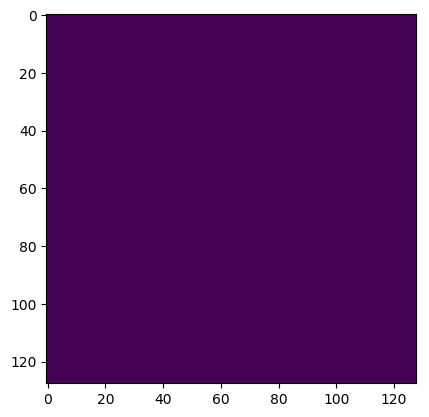

PyObject <matplotlib.image.AxesImage object at 0x7fbd675f6c88>

In [11]:
PyPlot.imshow(Array(yg[:, :, end]))

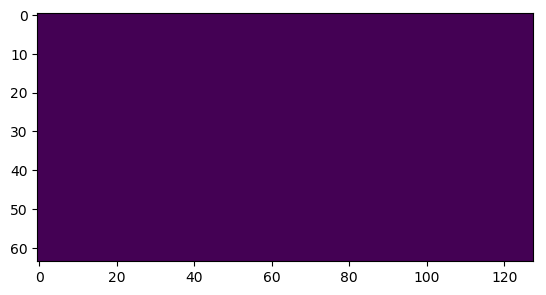

PyObject <matplotlib.image.AxesImage object at 0x7fbd67599208>

In [12]:
PyPlot.imshow(rotl90(Array(yg[32, :, :])))

In [8]:
Nx, Ny, Nz = 256, 256, 128
xc, yc = rand(Nx, Ny, Nz), rand(Nx, Ny, Nz);
xg, yg = cu(rand(Nx, Ny, Nz)), cu(rand(Nx, Ny, Nz));

In [16]:
@benchmark calc_div($xc, $yc)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     14.716 ms (0.00% GC)
  median time:      14.755 ms (0.00% GC)
  mean time:        14.834 ms (0.00% GC)
  maximum time:     26.022 ms (0.00% GC)
  --------------
  samples:          337
  evals/sample:     1

In [20]:
@benchmark CuArrays.@sync calc_div($xg, $yg)

BenchmarkTools.Trial: 
  memory estimate:  576 bytes
  allocs estimate:  14
  --------------
  minimum time:     158.750 μs (0.00% GC)
  median time:      175.023 μs (0.00% GC)
  mean time:        175.535 μs (0.00% GC)
  maximum time:     230.756 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [ ]:
@inline δx!(f, δxf, Nx, i, j, k) = (@inbounds δxf[i, j, k] = f[incmod1(i, Nx), j, k] - f[i, j, k])
@inline δy!(f, δyf, Ny, i, j, k) = (@inbounds δyf[i, j, k] = f[i, incmod1(j, Ny), k] - f[i, j, k])
@inline δz!(f, δzf, Nz, i, j, k) = (@inbounds δzf[i, j, k] = f[i, j, incmod1(k, Nz)] - f[i, j, k])
@inline div(f, Nx, Ny, Nz, i, j, k) = δx(f, Nx, i, j, k) + δy(f, Ny, i, j, k) + δz(f, Nz, i, j, k)

In [ ]:
function time_stepping_kernel(::Val{Dev}, f, ∇f) where Dev
    @setup Dev
    
    Nx, Ny, Nz = size(f)
    
    @loop for k in (1:Nz; blockIdx().z)
        @loop for j in (1:Ny; (blockIdx().y - 1) * blockDim().y + threadIdx().y)
            @loop for i in (1:Nx; (blockIdx().x - 1) * blockDim().x + threadIdx().x)
                @inbounds ∇f[i, j, k] = div(f, Nx, Ny, Nz, i, j, k)
            end
        end
    end
    
    @synchronize
end

time_step(A::Array, B::Array) = time_stepping_kernel(Val(:CPU), A, B)

function time_step(A::CuArray, B::CuArray)
    Nx, Ny, Nz = size(A)
    
    Tx, Ty = 16, 16  # Threads per block
    Bx, By, Bz = Int(Nx/Tx), Int(Ny/Ty), Nz  # Blocks in grid.
    
    # println("Threads per block: ($Tx, $Ty)")
    # println("Blocks in grid:    ($Bx, $By, $Bz)")
    
    @cuda threads=(Tx, Ty) blocks=(Bx, By, Bz) time_stepping_kernel(Val(:GPU), A, B)
end

In [18]:
@inline function f(x)
    @inbounds return x[1]
end

f (generic function with 1 method)

In [21]:
@benchmark f($xc)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     2.095 ns (0.00% GC)
  median time:      2.165 ns (0.00% GC)
  mean time:        2.156 ns (0.00% GC)
  maximum time:     9.568 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000